<center>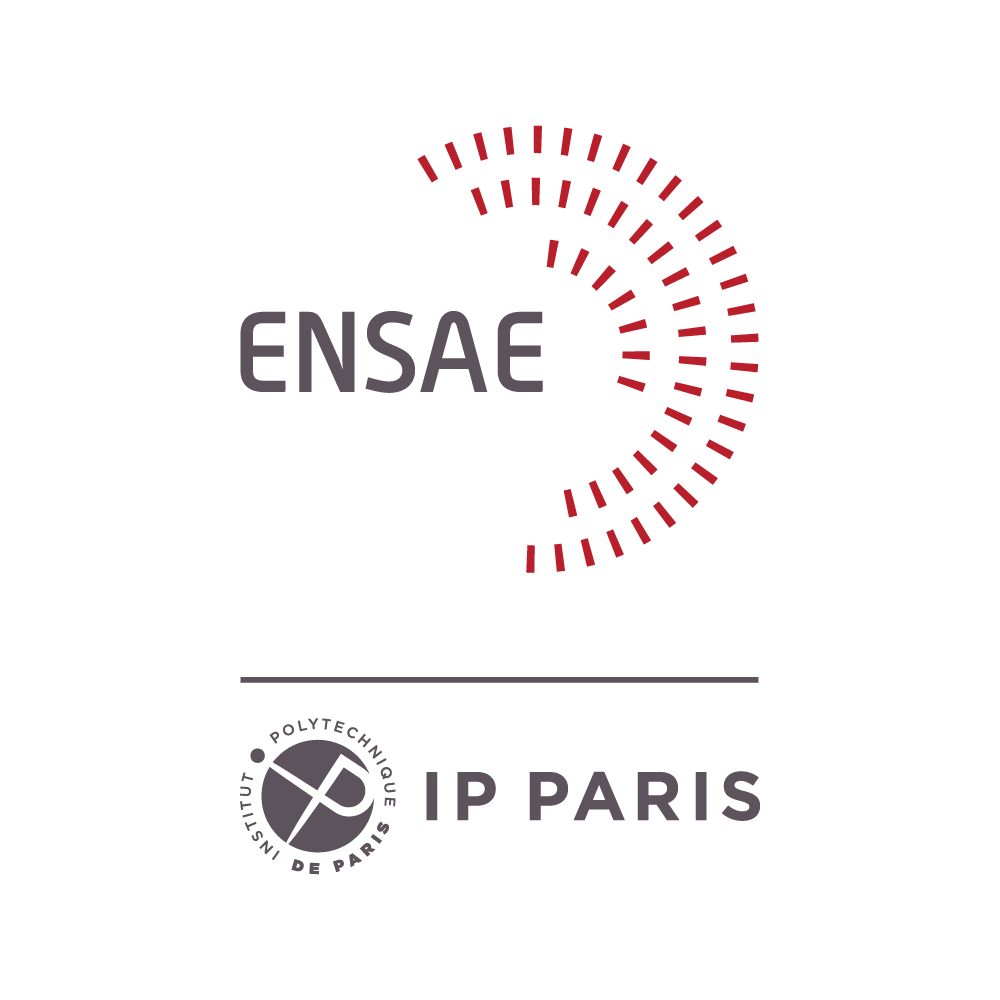</center>

<h1><center><strong><font color="chillipepper">Machine Learning for NLP</font></strong></center></h1>
<h3><center><font color="blue"><strong>Emeline Maire & Paul Petit 🎓</strong></font></center></h3>

<center>
Year 2022
</center>

------------------------

# Classification of poetry by artisits

dataset : https://www.kaggle.com/johnhallman/complete-poetryfoundationorg-dataset


------------------------

L'objectif de ce projet est à partir d'un ensemble de poèmes de retrouver leur auteur. Il s'agit donc d'un problème de classification en NLP. 

___
# <font color="chillipepper">**Imports and Installation**</font>

In [ ]:
! pip install torchinfo
! pip install datasets

     |████████████████████████████████| 325 kB 667 kB/s 
     |████████████████████████████████| 136 kB 11.6 MB/s 
     |████████████████████████████████| 1.1 MB 13.3 MB/s 
     |████████████████████████████████| 77 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 19.0 MB/s 
     |████████████████████████████████| 127 kB 42.3 MB/s 
     |████████████████████████████████| 271 kB 42.6 MB/s 
     |████████████████████████████████| 94 kB 2.1 MB/s 
     |████████████████████████████████| 144 kB 46.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

from functools import reduce
from operator import add
from termcolor import colored
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models.phrases import Phrases, Phraser

import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve,f1_score,fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV

from datasets import load_dataset
from datasets import Dataset as dts

from wordcloud import WordCloud

import gc

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

___
# <font color="chillipepper">**Data Loading**</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_paul='/content/drive/MyDrive/NLP ENSAE/projet NLP/'
df=pd.read_csv(path_paul+'poem_dataset.csv',index_col=0)

In [ ]:
df = pd.read_csv('Copie de poem_dataset.csv', index_col=0)

## <font color="chillipepper">**Data Basic Exploration**</font>

A quoi ressemble notre base de données ?

In [ ]:
print("Shape:  {0}".format(df.shape))
df.head()

Shape:  (15652, 4)


,Author,Title,Poetry Foundation ID,Content
0,Wendy Videlock,!,55489,"Dear Writers, I’m compiling the first in what ..."
1,Hailey Leithauser,0,41729,"Philosophic\nin its complex, ovoid emptiness,\..."
2,Jody Gladding,1-800-FEAR,57135,We'd like to talk with you about fear t...
3,Joseph Brodsky,1 January 1965,56736,The Wise Men will unlearn your name.\nAbove yo...
4,Ted Berrigan,3 Pages,51624,For Jack Collom\n10 Things I do Every Day\n\np...


Elle est plutôt fournie avec plus de 15000 poèmes et 3310 auteurs différents

In [ ]:
print("Number of authors: {}".format(len(df.Author.unique())))

Number of authors: 3310


A quoi ressemble un poème ?

In [ ]:
print("Auteur : {} \nTitre : {} \nTexte :".format(df.Author[1],df.Title[1]))
print(df.Content[1])

Auteur : Hailey Leithauser 
Titre : 0 
Texte :
Philosophic
in its complex, ovoid emptiness,
a skillful pundit coined it as a sort
of stopgap doorstop for those
quaint equations

Romans never
dreamt of. In form completely clever
and discrete—a mirror come unsilvered,
loose watch face without the works,
a hollowed globe

from tip to toe
unbroken, it evades the grappling
hooks of mass, tilts the thin rim of no thing,
remains embryonic sum,
non-cogito.


In [ ]:
# Mean length of content in characters
df.Content.drop_duplicates().apply(len).mean()

1423.6005243637294

Quels sont les auteurs qui apparaissent le plus souvent ?

In [ ]:
# We check the number of article per category
df.drop_duplicates().groupby(df.Author).size()[df.drop_duplicates().groupby(df.Author).size()>50]

Author
Alfred, Lord Tennyson    78
Anonymous                82
Emily Dickinson          57
Rae Armantrout           62
William Shakespeare      85
William Wordsworth       59
dtype: int64

___
# <font color="chillipepper">**Data Preparation**</font>

## <font color="chillipepper">**Re-define the corpus**</font>

Le corpus était très large, on garde seulement les poèmes d'auteurs apparaissant plus de 50 fois.

In [ ]:
# Keep in data only authors with most poems
data = df[df.Author.isin(df.drop_duplicates().groupby(df.Author).size()[df.drop_duplicates().groupby(df.Author).size()>50].index.values)].copy()

In [ ]:
del df
gc.collect()

44

Et l'on oublile pas de supprimer les auteurs anonymes.

In [ ]:
# Drop anonymous authors
data.drop(data[data.Author=='Anonymous'].index, inplace=True)

Il nous reste maintenant les auteurs suivants.

In [ ]:
print("Number of authors: {}".format(len(data.Author.unique())))

Number of authors: 5


In [ ]:
print("Shape:  {0}".format(data.shape))
data.drop_duplicates().groupby(data.Author).size()

Shape:  (341, 4)


Author
Alfred, Lord Tennyson    78
Emily Dickinson          57
Rae Armantrout           62
William Shakespeare      85
William Wordsworth       59
dtype: int64

On encode les labels (remplacement de l'auteur par un numéro), cela permet de les utliser dans les réseaux de neurones.

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data["Target"] = lb_make.fit_transform(data["Author"])

A quoi ressemble les poèmes restant ? Voici les 3 premiers de notre corpus :

In [ ]:
for i in range(1,4):
  print('Poem {}'.format(i))
  print('Author : {}'.format(data[i-1:i].Author.values[0]))
  print('Title : {}'.format(data[i-1:i].Title.values[0]))
  print(data[i-1:i].Content.values[0])
  print('\n')

Poem 1
Author : Rae Armantrout
Title : Accounts
Light was on its way
from nothing
to nowhere.

Light was all business

Light was full speed

when it got interrupted.

Interrupted by what?

When it got tangled up
and broke
into opposite

broke into brand new things.

What kinds of things?

Drinking Cup

“Thinking of you!
Convenience Valet”

How could speed take shape?


*

Hush!
Do you want me to start over?


*


The fading laser pulse

Information describing the fading laser pulse

is stored

is encoded

in the spin states
of atoms.

God
is balancing his checkbook

God is encrypting his account.

This is taking forever!


Poem 2
Author : Rae Armantrout
Title : Advent
In front of the craft shop,
a small nativity,
mother, baby, sheep
made of white
and blue balloons.


Poem 3
Author : Emily Dickinson
Title : After great pain, a formal feeling comes – (372)
After great pain, a formal feeling comes –
The Nerves sit ceremonious, like Tombs –
The stiff Heart questions ‘was it He, that bore,’

On supprime les colonnes inutiles et on récupère le nombre de label ainsi que les noms des auteurs correspondant au numéros de label

In [ ]:
data.drop(['Title','Poetry Foundation ID'],axis=1,inplace=True)

In [ ]:
names=lb_make.inverse_transform(np.sort(data["Target"].unique()))
nb_labels=len(data.Author.unique())

### <strong><font color="chillipepper"> Train / Test split </font></strong>

On sépare notre jeu de données en un échantillon de train et un de test.
On fait attention d'avoir bien un part minimum d'auteur dans chaque jeu.

In [ ]:
dataset = pd.concat([data["Target"],data["Content"]], axis=1)
X = dataset["Content"].copy()
y = dataset["Target"].copy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame() 

# Split by Author to be sure to have a min amount of poems per author in the train/test sets
for indiv in y.unique():
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X[y==indiv],y[y==indiv], test_size=0.3, random_state=42)
    X_train = pd.concat([X_train,X_train_])
    X_test = pd.concat([X_test,X_test_])
    y_train = pd.concat([y_train,y_train_])
    y_test = pd.concat([y_test,y_test_])


y_train = pd.Series([int(y) for y in y_train.values],index=y_train.index)
y_test = pd.Series([int(y) for y in y_test.values],index=y_test.index)

In [ ]:
dataset_train = dts.from_pandas(pd.DataFrame(pd.concat([X_train,y_train],axis=1)).set_axis(['text','label'], axis=1))
dataset_test= dts.from_pandas(pd.DataFrame(pd.concat([X_test,y_test],axis=1)).set_axis(['text','label'], axis=1))

dataset_train = dataset_train.remove_columns(["__index_level_0__"])
dataset_test = dataset_test.remove_columns(["__index_level_0__"])

### <strong><font color="chillipepper"> TF-IDF préparation </font></strong>


Fonction permettant de lemmatizer les textes pour le TF-IDF

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
def text_prep(corpus):
  _X=[]

  #text pre processing
  for _text in corpus[0]:
      text = re.sub('[^a-zA-Z]', ' ', _text)
      text = text.lower()
      text = text.split()
      text = [lemmatizer.lemmatize(word) for word in text if not word in set(stopwords)]
      text = ' '.join(text)
      _X.append(text)
  return _X

In [ ]:
train_X = pd.Series(text_prep(X_train),index=X_train.index)
test_X = pd.Series(text_prep(X_test),index=X_test.index)

### <strong><font color="chillipepper"> Data descritption </font></strong>

#### WordCloud  - premier exemple

Ici, on va un cran plus loin, on prend tous les mots des textes et on cherche à représenter la fréquence des mots utilisés par les auteurs. 

Pour cela, on va utiliser le package WordCloud - nuage de mots - qui prend en entrée une liste de mots. 

In [ ]:
! pip install wordcloud

In [ ]:
# Combine all training text into one large string
all_text = ' '.join([text for text in dataset.Content])
print('Number of words in all_text:', len(all_text))

Number of words in all_text: 489433


In [ ]:
word_list = word_tokenize(all_text)
word_list = [x.lower() for x in word_list]

# ensuite, on enlève les stopswords qui sont les mots comme if, then, the, and ... ainsi que la ponctuation

texts_clean = [w.lower() for w in word_list if w not in stopwords and w.isalpha()]
texts_clean = ' '.join(text.lower() for text in texts_clean)

In [ ]:
# Word cloud for entire training dataset
# default width=400, height=200

wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(texts_clean)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

#### Fréquence des mots

Une autre manière de voir la même chose, un histogramme avec le compte des mots les plus fréquents

In [ ]:
texts_list = texts_clean.split()
texts_counts = Counter(texts_list)
texts_common_words = [word[0] for word in texts_counts.most_common(25)]
texts_common_counts = [word[1] for word in texts_counts.most_common(25)]

plt.style.use('dark_background')
plt.figure(figsize=(15, 12))

sns.barplot(x=texts_common_words, y=texts_common_counts)
plt.title('Most Common Words used');

___

# <strong><font color="chillipepper"> Classification with TF-IDF </font></strong>


Notre premier classifier est basé sur TF-IDF, une fois les textes lémmatizés, on applique une forêt aléatoire afin de classer les textes par auteurs.

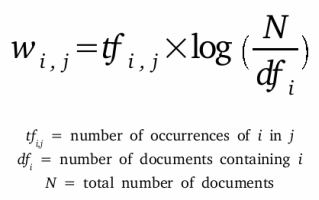

## <strong><font color="chillipepper">Text preparation with TF-IDF </font></strong>

On applique la transformation TF-IDF de sklearn.

In [ ]:
#tf idf
tf_idf = TfidfVectorizer()
#applying tf idf to training data
X_train_tf = tf_idf.fit_transform(train_X.values)
#applying tf idf to training data
X_train_tf = tf_idf.transform(train_X.values)

In [ ]:
print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 236, n_features: 7751


In [ ]:
#transforming test data into tf-idf matrix
X_test_tf = tf_idf.transform(test_X)

In [ ]:
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 105, n_features: 7751


## <strong><font color="chillipepper"> TF-IDF Classification </font></strong>

Maintenant que nous avons nos inputs on peut appliquer le classifieur

In [ ]:
fone_scorer = make_scorer(f1_score, average='weighted')

In [ ]:
clf = RandomForestClassifier(random_state=42, max_features = 'sqrt')

n_estimators = [500,1000] 
max_depth = [ 25, 50, None] 
parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth}
clf_VC = GridSearchCV(clf, parameters, cv=3, scoring=fone_scorer, verbose=1, n_jobs=-1,
    return_train_score=True,)

clf_VC.fit(X_train_tf,  y_train.values.ravel())
print('Returned hyperparameter: {}'.format(clf_VC.best_params_))
print('Best custom score on train is: {}'.format(clf_VC.best_score_))
print('Custom score on test is: {}'.format(clf_VC.score(X_test_tf, y_test)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Returned hyperparameter: {'max_depth': None, 'n_estimators': 1000}
Best custom score on train is: 0.5605265604053035
Custom score on test is: 0.6772588601332007


In [ ]:
#predicted y
y_pred_tfidf = clf_VC.best_estimator_.predict(X_test_tf)

Et voici les résultats :

In [ ]:
print(metrics.classification_report(y_test, y_pred_tfidf, target_names=names))

                       precision    recall  f1-score   support

Alfred, Lord Tennyson       0.89      0.67      0.76        24
      Emily Dickinson       0.52      0.72      0.60        18
       Rae Armantrout       0.87      0.68      0.76        19
  William Shakespeare       0.55      0.85      0.67        26
   William Wordsworth       1.00      0.39      0.56        18

             accuracy                           0.68       105
            macro avg       0.77      0.66      0.67       105
         weighted avg       0.76      0.68      0.68       105



In [ ]:
cm = confusion_matrix(np.array(y_test).flatten(), np.array(y_pred_tfidf).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

Pas trop mal pour le TF-IDF, avec un f1 score de 0.68 !
On remarque que l'algorithme à tendance à trop prédire Shakespeare et à du mal à prédire Wordsworth corresctement

Nos algorithmes utilisant le word embedding et un réseau de neuronnes arriveront-ils à faire mieux ?

___
# <strong><font color="chillipepper">**Sequence Classification** </font></strong>

## <font color="chillipepper">Import Pre-trained Embeddings</font> 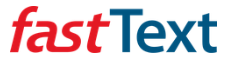

import des embeddings pré-entrainés

In [ ]:
# fasttext vectors can be imported through torch text (it will download it only once)
from torchtext.vocab import GloVe, vocab, FastText

# pretrained_vectors = GloVe(name="6B", dim='50')
pretrained_vectors = FastText(language='en')

.vector_cache/wiki.en.vec: 6.60GB [03:18, 33.3MB/s]                            
100%|██████████| 2519370/2519370 [05:07<00:00, 8187.25it/s]


Ajout des tokens incconus dans le vocabulaire avec `pretrained_vocab.insert_token("<unk>",unk_index)`.

In [ ]:
from torchtext.vocab import GloVe, FastText, vocab

pretrained_vocab = vocab(pretrained_vectors.stoi, min_freq=0)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(2,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2519372, 300])

### <font color="chillipepper">Tokenize, numericalize, and trim and pad the data</font>

On utilise le TreebankWordTokenizer comme tokenizer.

In [ ]:
tok = TreebankWordTokenizer()
tok.tokenize("I have a new GPU!".lower())

['i', 'have', 'a', 'new', 'gpu', '!']

In [ ]:
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=100):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry)[:max_length+10]]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def tokenize_all(entries, vocab_stoi, max_length=100):
  res = {}
  res['label'] = torch.tensor(entries['label']).type(torch.LongTensor)
  res['text'] = torch.tensor([tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']])
  return res

On applique la tokenization à notre jeu de données

In [ ]:
dataset = {"train": dataset_train,
           "test": dataset_test}

poem_tok_eval = {"train": tokenize_all(dataset['train'],pretrained_vocab.get_stoi()),
           "test": tokenize_all(dataset['test'],pretrained_vocab.get_stoi())}

Complete the Dataset class

On créer la classe PoemsDataset retournant un dataset qui nous permettera d'énumerer sur chaque élement avec `__getitem__` de la forme `dict_keys(['text', 'label'])`.

In [ ]:
class PoemsDataset(Dataset):
    def __init__(self, dct=dict()):
      super().__init__()
      self.dct = dct

    def __len__(self):
      return len(self.dct["text"])
    
    def __getitem__(self, idx):
      item = {
          "text": self.dct["text"][idx],
          "label": self.dct["label"][idx]
      }
      # warning: if you put   self.data['text'][idx]    it will take A LOT of time...
      ## The following code would take forever just to print next(iter(train_loader))['text'].shape
      # item = {
      #     "text": np.array(self.data['text'][idx]),
      #     "label": np.array(self.data['label'][idx])
      # }
      return item

On peut maintenant créer les DataLoaders de notre custom Dataset class.

In [ ]:
# Create DataLoader

bsize= 16
train_loader = DataLoader(PoemsDataset(poem_tok_eval['train']), batch_size=bsize, num_workers=2, shuffle=True, drop_last=False)
test_loader   = DataLoader(PoemsDataset(poem_tok_eval['test']), batch_size=bsize, num_workers=2, shuffle=True, drop_last=False)

next(iter(train_loader))['text'].shape

torch.Size([16, 200])

## <font color="chillipepper">Pytorch Model</font>

On va définir un model de deep learning simple, l'entrainer sur le jeu de donnée et raliser des prévisions.

With pytorch this means doing the three following "scripts" : 
1. Defining the model 
2. Implementing the prediction 
3. Implementing the training loop 
    - Defining a loss
    - Defining an optimizer
    - Loop :
        - forward pass 
        - backward pass
        - applying optimization update rule
4. Evaluating the model / playing with it 


### <font color="chillipepper"> PoemModel</font>

In [ ]:
class PoemModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(PoemModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [ ]:
sizes = next(iter(train_loader))['text'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

16 200


In [ ]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = nb_labels # because there is nb_labels classes, i.e. nb_labels authors
# we instanciate the model
poem_model = PoemModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [ ]:
# we can look at the model 
poem_model

PoemModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
poem_model.to(device)

DEVICE =  CPU


PoemModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
next(poem_model.parameters()).is_cuda

False

In [ ]:
from torchinfo import summary
# to prevent some bugs, move the model to CPU, then move it back to cuda (using the device variable)
# with verbose set to 2 we have more information. however a bug makes it print twice...
print(summary(poem_model.to('cpu'), (batchsize, inputdim), dtypes=['torch.IntTensor'], device='cpu', verbose=2))
poem_model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
PoemModel                                --                        --
├─Embedding: 1-1                         [16, 200, 300]            (755,811,000)
│    └─weight                                                      └─755,811,000
├─Linear: 1-2                            [16, 300]                 90,300
│    └─weight                                                      ├─90,000
│    └─bias                                                        └─300
├─Linear: 1-3                            [16, 5]                   1,505
│    └─weight                                                      ├─1,500
│    └─bias                                                        └─5
├─Softmax: 1-4                           [16, 5]                   --
Total params: 755,902,805
Trainable params: 91,805
Non-trainable params: 755,811,000
Total mult-adds (G): 12.09
Input size (MB): 0.01
Forward/backward pass size (MB): 7.72
Params si

PoemModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

###  <font color="chillipepper">Training Loop as a function (to incorporate validation)</font> 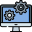

#### <font color="chillipepper">3. Training loop </font>

- Criterion : 
    - Categorical Cross-Entropy

- Optimizer :

In pytorch as in any deep learning framework (Tensorflow for instance), models are trained with backpropagation. Backpropagation consists in applying Stochastic Gradient Descent (SGD) to a neural network. There is a broad range of variants around the simple form of SGD. 
  - Adam 


- Training Loop :
    - forward pass to get prediction and the loss value (what a coincidence we have a `forward()` function in our model! 🙂)
    - zero_grad : Resetting the gradient value to zero for all parameters before adding their newly backpropagated values (this step is crucial!) 
    - compute the gradients' value with `loss.backward()`
    - update all the parameters of the model with `optimizer.step()`

In [ ]:
def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['text'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    # loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


### <font color="chillipepper">Inference Loop as a function</font> 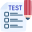

In [ ]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

### <font color="chillipepper">Start Training 📉</font>

In [ ]:
import torch.optim as optim

def run_epochs(model, args):

  args['device'] =device
  # if args['cuda'] != -1:
  #     model.cuda(args['cuda'])
  #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #     args['device'] = device
  #     print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("test", test_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [ ]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args = {'bsize': bsize}
args.update({'max_eps': 40, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': nb_labels})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
# model = PoemModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
poem_model = PoemModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(poem_model, args)

device cpu


Epoch 0::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/40 : Training : (loss 1.598289426167806) (acc 0.24722222288449605)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.5866670608520508) (acc 0.2460317462682724)


Epoch 1::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/40 : Training : (loss 1.5618460337320963) (acc 0.27222222288449605)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.5573182616915022) (acc 0.2886904776096344)


Epoch 2::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/40 : Training : (loss 1.531772208213806) (acc 0.3361111104488373)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.5352732624326433) (acc 0.3154761918953487)


Epoch 3::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/40 : Training : (loss 1.5130375385284425) (acc 0.34722222288449606)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.5213532447814941) (acc 0.37996031769684385)


Epoch 4::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/40 : Training : (loss 1.4908016045888266) (acc 0.42361111044883726)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.498773489679609) (acc 0.4404761918953487)


Epoch 5::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/40 : Training : (loss 1.4832179148991902) (acc 0.4555555542310079)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4837169306618827) (acc 0.4523809552192688)


Epoch 6::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/40 : Training : (loss 1.481379795074463) (acc 0.4694444437821706)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4882088218416487) (acc 0.44543651172092985)


Epoch 7::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/40 : Training : (loss 1.4643458763758341) (acc 0.45138888955116274)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4774228164127894) (acc 0.43154762046677725)


Epoch 8::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/40 : Training : (loss 1.4602675755818686) (acc 0.4666666666666667)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.470118761062622) (acc 0.47420634967940195)


Epoch 9::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/40 : Training : (loss 1.4484812895456949) (acc 0.47222222288449606)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4604580572673254) (acc 0.4563492068222591)


Epoch 10::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/40 : Training : (loss 1.4449515024820963) (acc 0.42916666666666664)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4512986285345895) (acc 0.5148809552192688)


Epoch 11::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/40 : Training : (loss 1.438622538248698) (acc 0.44166666666666665)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4465536049434118) (acc 0.46726190618106295)


Epoch 12::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/40 : Training : (loss 1.4386688868204753) (acc 0.5180555542310079)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4459731238228934) (acc 0.4722222260066441)


Epoch 13::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/40 : Training : (loss 1.437105162938436) (acc 0.486111111442248)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4280362980706351) (acc 0.49007936886378695)


Epoch 14::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/40 : Training : (loss 1.4175913174947103) (acc 0.5041666666666667)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4405609709875924) (acc 0.5059523837906974)


Epoch 15::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/40 : Training : (loss 1.4149721701939901) (acc 0.522222222884496)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4142586163112096) (acc 0.5059523837906974)


Epoch 16::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/40 : Training : (loss 1.4236416896184285) (acc 0.5208333333333334)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4292191437312536) (acc 0.49007936886378695)


Epoch 17::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17/40 : Training : (loss 1.4126826604207356) (acc 0.5263888895511627)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4153413942881994) (acc 0.5059523837906974)


Epoch 18::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/40 : Training : (loss 1.4070541143417359) (acc 0.5180555562178294)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4256625005177088) (acc 0.4920634925365448)


Epoch 19::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/40 : Training : (loss 1.401760220527649) (acc 0.5222222208976746)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4160209894180298) (acc 0.49404762046677725)


Epoch 20::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/40 : Training : (loss 1.3832543770472208) (acc 0.5430555542310079)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4062437670571464) (acc 0.48511904903820585)


Epoch 21::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21/40 : Training : (loss 1.3749229907989502) (acc 0.5638888875643412)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4026262760162354) (acc 0.5099206353936877)


Epoch 22::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22/40 : Training : (loss 1.36057870388031) (acc 0.5513888875643412)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3914014782224382) (acc 0.5168650831495013)


Epoch 23::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23/40 : Training : (loss 1.3561646223068238) (acc 0.5708333333333333)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4311514241354806) (acc 0.5009920639651162)


Epoch 24::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24/40 : Training : (loss 1.3531319538752238) (acc 0.5777777791023254)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.4008798939841134) (acc 0.47817460341112955)


Epoch 25::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25/40 : Training : (loss 1.3689185937245687) (acc 0.5486111104488373)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3827964748655046) (acc 0.5416666695049831)


Epoch 26::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26/40 : Training : (loss 1.3734458287556965) (acc 0.5666666666666667)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3906219857079642) (acc 0.5257936545780727)


Epoch 27::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27/40 : Training : (loss 1.3404941797256469) (acc 0.5611111104488373)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3827747106552124) (acc 0.5545634925365448)


Epoch 28::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28/40 : Training : (loss 1.3725881258646646) (acc 0.5819444457689921)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.392449004309518) (acc 0.5009920639651162)


Epoch 29::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29/40 : Training : (loss 1.3485522667566936) (acc 0.5819444437821706)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.378504855292184) (acc 0.5436507974352155)


Epoch 30::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30/40 : Training : (loss 1.3430507977803547) (acc 0.5680555542310078)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3891441311155046) (acc 0.5277777782508305)


Epoch 31::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 31/40 : Training : (loss 1.3276614745457966) (acc 0.5777777791023254)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.373345238821847) (acc 0.5863095266478402)


Epoch 32::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 32/40 : Training : (loss 1.3461870829264322) (acc 0.5986111124356588)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3906913825443812) (acc 0.5188492068222591)


Epoch 33::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 33/40 : Training : (loss 1.331295379002889) (acc 0.5916666666666667)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3770447628838676) (acc 0.5277777782508305)


Epoch 34::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 34/40 : Training : (loss 1.3180922985076904) (acc 0.6208333333333333)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3693594251360213) (acc 0.5753968272890363)


Epoch 35::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 35/40 : Training : (loss 1.3218710978825887) (acc 0.6111111124356587)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3858309643609183) (acc 0.5257936545780727)


Epoch 36::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 36/40 : Training : (loss 1.324393081665039) (acc 0.6222222208976745)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3846850906099593) (acc 0.5277777782508305)


Epoch 37::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 37/40 : Training : (loss 1.3173827091852823) (acc 0.5986111104488373)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3652399267469133) (acc 0.5545634925365448)


Epoch 38::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 38/40 : Training : (loss 1.325390640894572) (acc 0.6097222208976746)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3832752364022392) (acc 0.5277777782508305)


Epoch 39::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 39/40 : Training : (loss 1.3054765065511067) (acc 0.6416666666666667)


test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.354187982422965) (acc 0.5575396844318935)


Now let's plot the validation loss.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

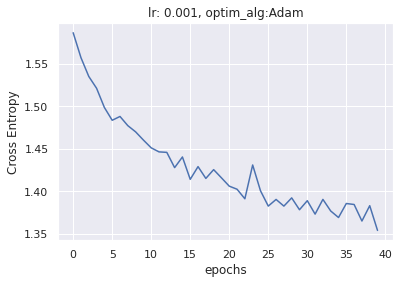

In [ ]:
# let's call our function using the list of validation losses to show the plot
plot_loss(loss_list_val)

### <font color="chillipepper">Evaluate the Model 📊</font>

On utilise la fonction d'inference pour appliquer le modèle au test set.

In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, y_pred_nn, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, poem_model)

test::   0%|          | 0/7 [00:00<?, ?it/s]

test : (loss 1.3605257953916277) (acc 0.5505952409335545)


Plot the classification report

In [ ]:
print(classification_report(np.array(trues).flatten(), np.array(y_pred_nn).flatten(), target_names=names))

                       precision    recall  f1-score   support

Alfred, Lord Tennyson       0.36      0.50      0.42        24
      Emily Dickinson       0.67      0.67      0.67        18
       Rae Armantrout       0.74      0.74      0.74        19
  William Shakespeare       0.57      0.65      0.61        26
   William Wordsworth       0.40      0.11      0.17        18

             accuracy                           0.54       105
            macro avg       0.55      0.53      0.52       105
         weighted avg       0.54      0.54      0.52       105



Let's print the confusion matrix. This is the core part to dive into model's performance indications.

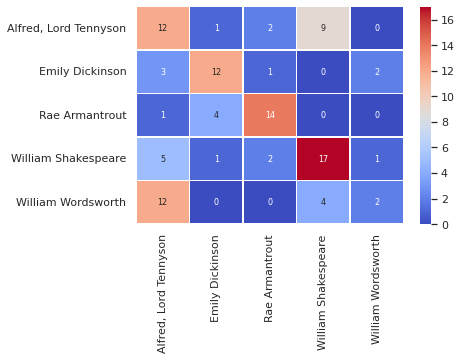

In [ ]:
cm = confusion_matrix(np.array(trues).flatten(), np.array(y_pred_nn).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

Notre premier modèle de deep learning fait donc beaucoup moins bien que le TF-IDF. Lui aussi a du mal à classifier Woodsworth mais il a aussi beuacoup de mal à correctement classifier Lord Tennyson. 

___
# <strong><font color="chillipepper">**What about BERT?** </font></strong>



Dans cette partie on va utiliser le modèle BERT pré-entrainé pour classifier nos auteurs. on utilise `bert-tiny` qui est une petit version de BERT plus rapide à entrainer.

### <font color="chillipepper"> Préparation et autotokenization </font>

In [ ]:
! pip install transformers

     |████████████████████████████████| 4.0 MB 6.8 MB/s 
     |████████████████████████████████| 895 kB 45.1 MB/s 
     |████████████████████████████████| 6.6 MB 32.2 MB/s 
     |████████████████████████████████| 596 kB 55.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
dataset = {"train": dataset_train,
           "test": dataset_test}

In [ ]:
tokenized_datasets = {"train": "",
           "test": ""}

for split in ["train","test"]:
  tokenized_datasets[split] = dataset[split].map(tokenize_function)
  tokenized_datasets[split] = tokenized_datasets[split].remove_columns(["text"])
  tokenized_datasets[split] = tokenized_datasets[split].rename_column("label", "labels")
  tokenized_datasets[split].set_format("torch")

  0%|          | 0/236 [00:00<?, ?ex/s]

  0%|          | 0/105 [00:00<?, ?ex/s]

In [ ]:
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8)
test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8)

### <font color="chillipepper"> Défintion de BERT </font>

In [ ]:
from transformers import AutoModelForSequenceClassification
# This model is equal to BERT + a linear layer for classification. In our custom model we designed a FastText + a hidden layer and linear layer for classification
bert = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=nb_labels)

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [ ]:
from torch.optim import AdamW
optimizer = AdamW(bert.parameters(), lr=5e-5)

In [ ]:
from transformers import get_scheduler

num_epochs = 30
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))

DEVICE =  CPU


### <font color="chillipepper"> Training BERT </font>

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

bert.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = bert(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/900 [00:00<?, ?it/s]

### <font color="chillipepper"> Predecting with BERT </font>

In [ ]:
from datasets import load_metric
metric = load_metric("accuracy")
bert.eval()
preds, trues = [], []
for i, batch in tqdm(enumerate(test_dataloader), desc="evaluating", total=test_dataloader.__len__()):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = bert(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

    _, tag_seq  = torch.max(logits, 1)
    preds.extend(tag_seq.cpu().detach().tolist())
    trues.extend(batch['labels'].cpu().detach().tolist())

metric.compute()

evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

{'accuracy': 0.7333333333333333}

In [ ]:
y_pred_bert = preds

In [ ]:
print(classification_report(np.array(trues).flatten(), np.array(y_pred_bert).flatten(), target_names=names))

                       precision    recall  f1-score   support

Alfred, Lord Tennyson       0.52      0.71      0.60        24
      Emily Dickinson       0.89      0.94      0.92        18
       Rae Armantrout       0.86      0.95      0.90        19
  William Shakespeare       0.76      0.73      0.75        26
   William Wordsworth       0.86      0.33      0.48        18

             accuracy                           0.73       105
            macro avg       0.78      0.73      0.73       105
         weighted avg       0.76      0.73      0.72       105



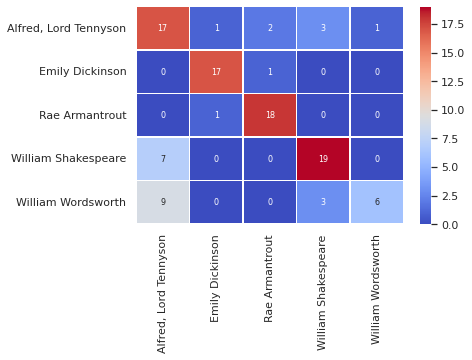

In [ ]:
cm = confusion_matrix(np.array(trues).flatten(), np.array(y_pred_bert).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

BERT fait beaucoup mieux que notre premier modèle de deep learning, mais un peu moins bien que le TF-IDF. Comme le modèle précédent, il performe mal pour Woodsworth et Lord Tennyson. 

___
# <font color="chillipepper">**Rhyme analysis** </font>

Le but de cette partie est d'étudier les rimes des poèmes. On s'intéresse ici à la dernière sylabe de chaque vers et on va regarder si sa prononciation est similaire à celles des phrases alentours.

Pour limiter les temps de calculs nous nous intéressons seulement aux 3 premiers vers de chaque poème et cherchons à trouver la structure des rimes si il y en a. Par ailleurs nous regardons aussi la longueur du poème en nombre de vers ainsi que le nombre de strophes

In [ ]:
nltk.download('cmudict')

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


True

In [ ]:
def rhyme_shape(text, entries):

#Short version

  lin=(text).replace(",","").replace(".","").replace(";","").replace(":","").replace("!","").replace("-"," ")
  line=lin.splitlines()
  nb_vers=1
  nb_lines=len(line)
  for lin in line:
    if lin=="":
      nb_vers+=1
  line=[lin for lin in line if lin!=""]
  i=0
  Set=[]
  Sentence_set=[]
  result=[]
  # Analyses only the 4 first lines
  for li in line[:3]:
    Sentence_set.append(li)
    sp=li.split()
    if ("".join(sp[-1:]) is None or  len("".join(sp[-1:])) == 0 or "".join(sp[-1:])==" "):
        continue
    #print (str(i)+" "+"".join(sp[-1:]))
    Set.append("".join(sp[-1:]) )
    if(len(Set)%3==0):
        result_verse = verse_Rhyme(Set,entries)
        result.append(result_verse)
        i=i+1
  return(result,nb_lines,nb_vers)

def verse_Rhyme(Set, entries):
    result="--No Rhyme--"
    r_1_2 = doTheyRhyme(Set[0], Set[1] ,entries)
    r_2_3 = doTheyRhyme(Set[1], Set[2] ,entries)
    r_1_3 = doTheyRhyme(Set[0], Set[2] ,entries)
    if(  r_1_2 ==True and  r_2_3 ==True):
        result = "--AAA--"
    elif ( r_1_2==True):
        result = "--AAB--"
    elif ( r_1_3==True):
        result = "--ABA--"
    elif ( r_2_3==True):
        result = "--ABB--"
    return result

def get_syllables(inp,entries):
    syllables = [(word, syl) for word, syl in entries if word == inp]
    rhymes = []
    return syllables


def doTheyRhyme ( word1, word2 ,entries,level=1):
    a=get_syllables(word1,entries)
    b=get_syllables(word2,entries)
    if a!=[]:
      a=a[0][-1][-level:][0]
    if b!=[]:
      b=b[0][-1][-level:][0]
    return a == b


def rythm_poem(poem, entries):
    list_form,nb_lines,nb_verses = rhyme_shape(poem, entries)
    AAA = list_form.count("--AAA--")
    AAB = list_form.count("--AAB--")
    ABA = list_form.count("--ABA--")
    ABB = list_form.count("--ABB--")
    No_Rhyme= list_form.count("--No Rhyme--")
    return {'AAA':AAA,'AAB':AAB,'ABA':ABA,'ABB':ABB,'No_Rhyme':No_Rhyme,'nb_lines':nb_lines,'nb_verses':nb_verses}
    

In [ ]:
def poems_rythm_analysis(corpus, entries):
  results=[]
  for poem in tqdm(corpus):
    results.append(rythm_poem(poem,entries))
  return results

In [ ]:
entries = nltk.corpus.cmudict.entries()


In [ ]:
X_rhyme_train=poems_rythm_analysis(dataset_train['text'], entries)
X_rhyme_test=poems_rythm_analysis(dataset_test['text'], entries)

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

## <font color="chillipepper"> Random Forest Rhyme classification </font>

Avec les informations obtenues sur la compositions des rimes du poème nous allons faire tourner une forêt aléatoire afin d'essayer de classifier nos auteurs.

In [ ]:
fone_scorer = make_scorer(f1_score, average='weighted')

In [ ]:
clf_r = RandomForestClassifier(random_state=42, max_features = 'sqrt')

n_estimators = [500,1000] 
max_depth = [ 25, 50, None] 
parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth}
clf_r_VC = GridSearchCV(clf_r, parameters, cv=3, scoring=fone_scorer, verbose=1, n_jobs=-1,
    return_train_score=True,)

clf_r_VC.fit(pd.DataFrame(X_rhyme_train,index=y_train.index),  y_train.values.ravel())
print('Returned hyperparameter: {}'.format(clf_r_VC.best_params_))
print('Best custom score on train is: {}'.format(clf_r_VC.best_score_))
print('Custom score on test is: {}'.format(clf_r_VC.score(pd.DataFrame(X_rhyme_test,index=y_test.index), y_test)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Returned hyperparameter: {'max_depth': 25, 'n_estimators': 500}
Best custom score on train is: 0.6838380653464505
Custom score on test is: 0.6432803848702217


In [ ]:
#predicted y
y_pred_r = clf_r_VC.best_estimator_.predict(pd.DataFrame(X_rhyme_test,index=y_test.index))

In [ ]:
print(metrics.classification_report(y_test, y_pred_r, target_names=names))

                       precision    recall  f1-score   support

Alfred, Lord Tennyson       0.65      0.71      0.68        24
      Emily Dickinson       0.60      0.67      0.63        18
       Rae Armantrout       0.71      0.63      0.67        19
  William Shakespeare       0.74      0.88      0.81        26
   William Wordsworth       0.45      0.28      0.34        18

             accuracy                           0.66       105
            macro avg       0.63      0.63      0.63       105
         weighted avg       0.64      0.66      0.64       105



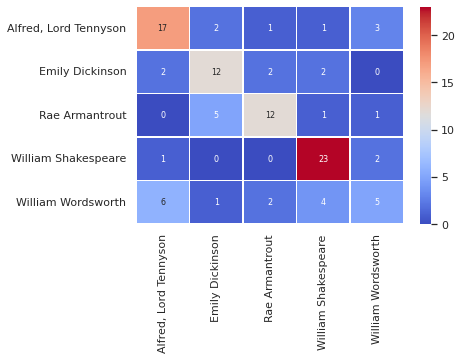

In [ ]:
cm = confusion_matrix(y_test, y_pred_r)
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

Pas si mal pour un algorithme assez simple, c'est presque aussi bien que le TF-IDF et BERT. Encore une fois c'est William Wordsworth qui est le plus difficle à classifier avec un très mauxais Recall.

___
# <font color="chillipepper">**Summary of the classifiers** </font>

TF-IDF + Random Forest

In [ ]:
print(metrics.classification_report(y_test, y_pred_tfidf, target_names=names))

                       precision    recall  f1-score   support

Alfred, Lord Tennyson       0.89      0.67      0.76        24
      Emily Dickinson       0.52      0.72      0.60        18
       Rae Armantrout       0.87      0.68      0.76        19
  William Shakespeare       0.55      0.85      0.67        26
   William Wordsworth       1.00      0.39      0.56        18

             accuracy                           0.68       105
            macro avg       0.77      0.66      0.67       105
         weighted avg       0.76      0.68      0.68       105



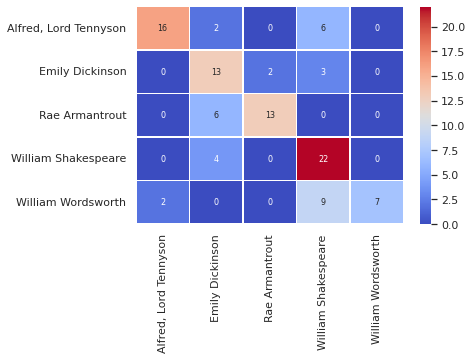

In [ ]:
cm = confusion_matrix(np.array(y_test).flatten(), np.array(y_pred_tfidf).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

Neural Net

In [ ]:
print(classification_report(np.array(trues).flatten(), np.array(y_pred_nn).flatten(), target_names=names))

                       precision    recall  f1-score   support

Alfred, Lord Tennyson       0.42      0.58      0.49        24
      Emily Dickinson       0.22      0.22      0.22        18
       Rae Armantrout       0.21      0.21      0.21        19
  William Shakespeare       0.23      0.27      0.25        26
   William Wordsworth       0.00      0.00      0.00        18

             accuracy                           0.28       105
            macro avg       0.22      0.26      0.23       105
         weighted avg       0.23      0.28      0.25       105



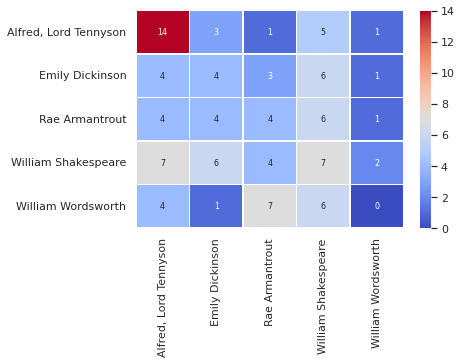

In [ ]:
cm = confusion_matrix(np.array(trues).flatten(), np.array(y_pred_nn).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

BERT

In [ ]:
print(classification_report(np.array(trues).flatten(), np.array(y_pred_bert).flatten(), target_names=names))

                       precision    recall  f1-score   support

Alfred, Lord Tennyson       0.52      0.71      0.60        24
      Emily Dickinson       0.89      0.94      0.92        18
       Rae Armantrout       0.86      0.95      0.90        19
  William Shakespeare       0.76      0.73      0.75        26
   William Wordsworth       0.86      0.33      0.48        18

             accuracy                           0.73       105
            macro avg       0.78      0.73      0.73       105
         weighted avg       0.76      0.73      0.72       105



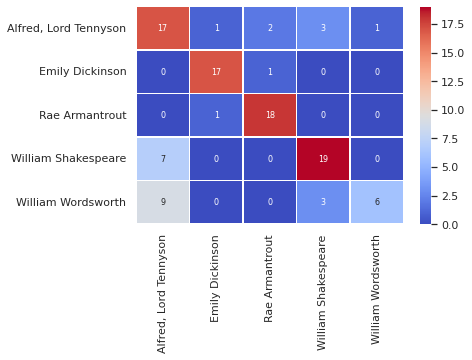

In [ ]:
cm = confusion_matrix(np.array(trues).flatten(), np.array(y_pred_bert).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

Rhyme analysis + Random Forest

In [ ]:
print(metrics.classification_report(y_test, y_pred_r, target_names=names))

                       precision    recall  f1-score   support

Alfred, Lord Tennyson       0.65      0.71      0.68        24
      Emily Dickinson       0.60      0.67      0.63        18
       Rae Armantrout       0.71      0.63      0.67        19
  William Shakespeare       0.74      0.88      0.81        26
   William Wordsworth       0.45      0.28      0.34        18

             accuracy                           0.66       105
            macro avg       0.63      0.63      0.63       105
         weighted avg       0.64      0.66      0.64       105



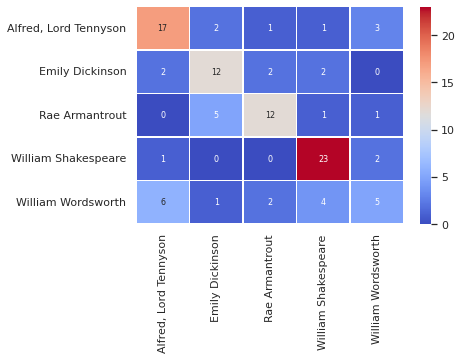

In [ ]:
cm = confusion_matrix(y_test, y_pred_r)
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()